In [1]:
# Copy these import statements to your notebook
import sys
sys.path.append(".")  # Add current directory to path

from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from model import forward_hook
from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# Change this line from a relative import to an absolute import
from plot.utils import load_model, plot_attns
from two_hop_data import multi_hop_format, iterate_batches
%load_ext autoreload
%autoreload 2


In [2]:
def numsToPos(seq, nums, ):
    for num in nums:
        for idx in torch.where(seq == num):
            yield idx


In [ ]:
device = "cuda:3"
torch.cuda.set_device(device)
layer = 3
head = 1
steps = 400
run_path=f"../runs/multi_hop_2_L3_seq_len_24_lr_0.0003"
cfg, model, seqs, seqs_ans_pos_start, seqs_ans_pos_end = load_model(layer, head, steps, run_path, get_loss=True, device=device)

Layer 0, Head 0


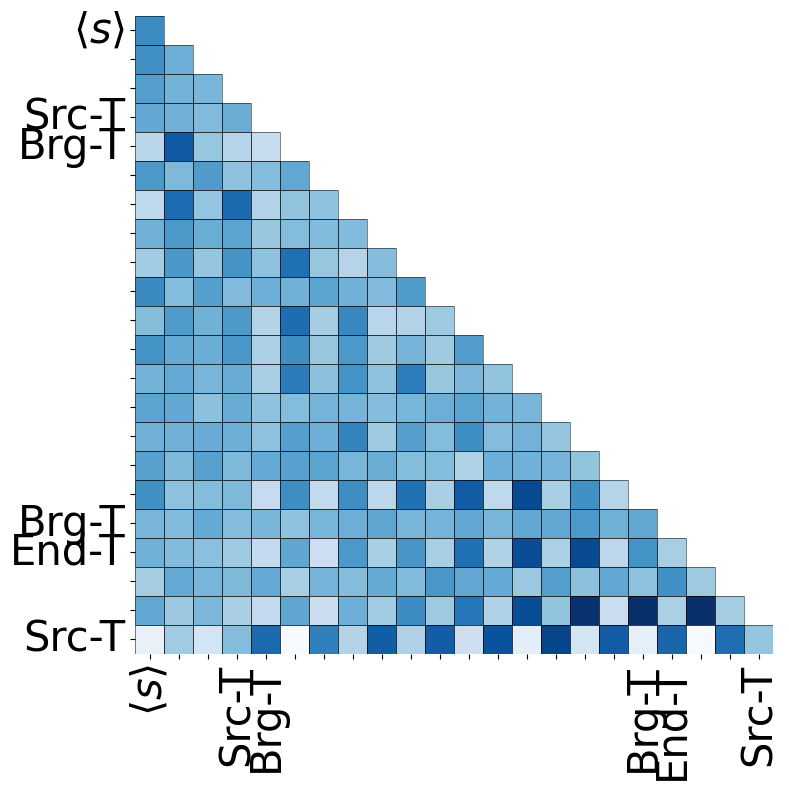

Layer 1, Head 0


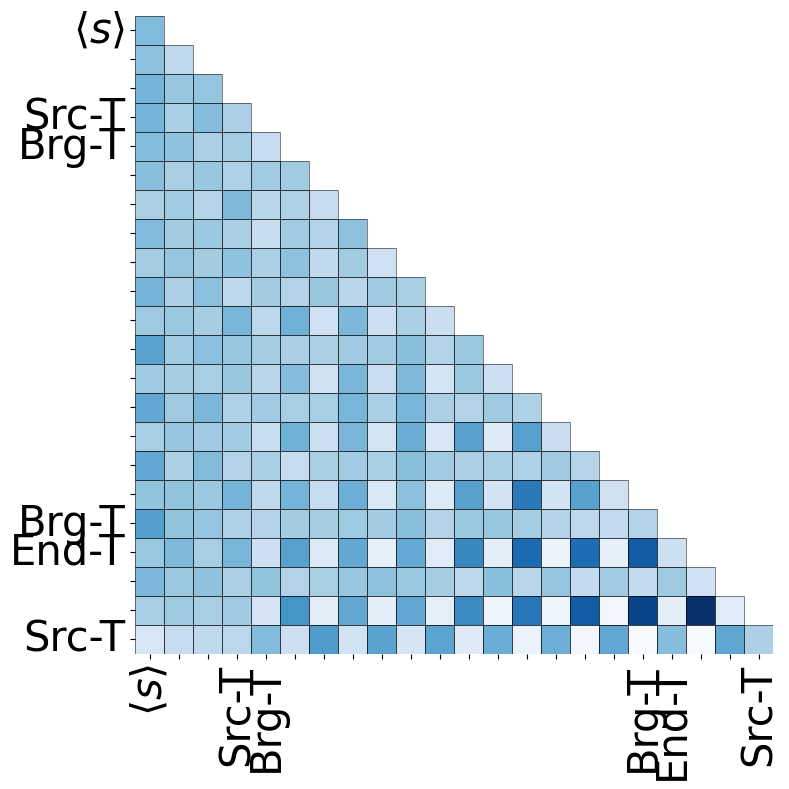

Layer 2, Head 0


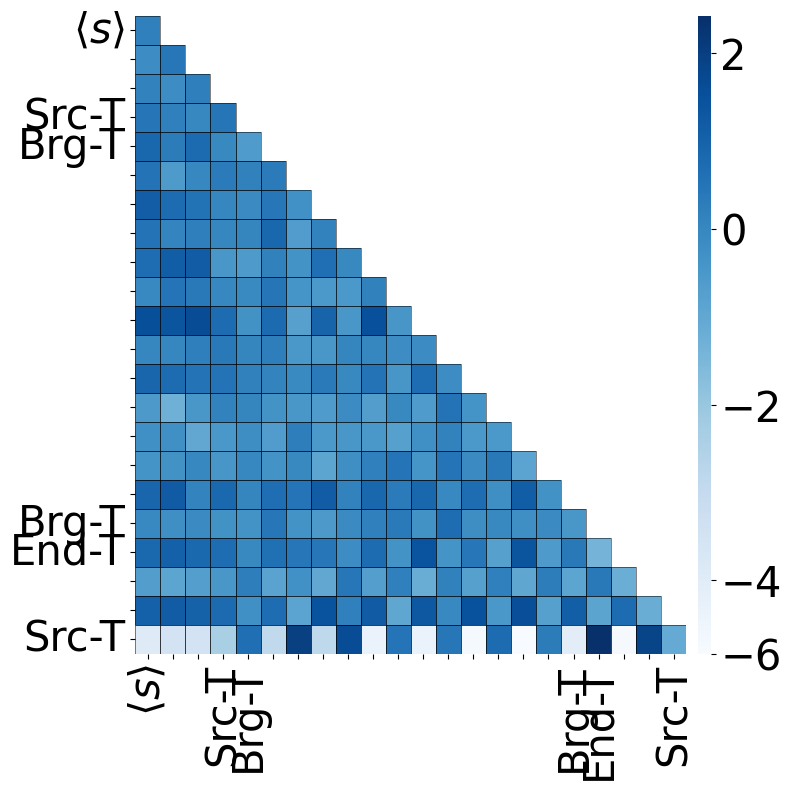

In [4]:
ds = multi_hop_format(cfg.data_args)

seqs, seqs_ans_pos_start, seqs_ans_pos_end, twoSum, oneSum = next(iterate_batches(ds, num_workers=48, seed=42, batch_size=512, total_count=1, withhops=True))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(torch.LongTensor(seqs)[:, :-1].cuda(), hook)
x = torch.LongTensor(seqs)[:, :-1].cuda()
y = torch.LongTensor(seqs)[:, 1:].cuda()


seq_indices = 0
seq_start = 0
seq_len = seqs_ans_pos_start[0] + 1

numToChr = {twoSum[seq_indices]['target']['start'][0]: 'Src-T', twoSum[seq_indices]['target']['mid'][0]: 'Brg-T', twoSum[seq_indices]['target']['end'][0]: 'End-T', seqs_ans_pos_start[seq_indices]: 'Query'}

plot_attns(seqs, outputs_list, seq_indices, seq_start, seq_len, layer, head, numToChr)

In [28]:
model.layers[2].attention.wo

Linear(in_features=256, out_features=256, bias=False)

In [31]:
logit_lens = []
prob_lens = []
pred2 = model.output(model.norm(outputs_list[1]['output']))
prob2_lens = []

for seq_indices in range(len(seqs)):
    seq = seqs[seq_indices]
    normalized_values = model.norm(model.layers[2].attention.wo(outputs_list[2]['value_states'][seq_indices, 0, :, :]))
    output_values = model.output(normalized_values).T

    # Extract indices from twoSum[0]
    mid_indices = [twoSum[seq_indices]['target']['mid'][0]] + twoSum[seq_indices]['noise']['mid']  # [24, 6, 8, 23, 20]
    end_indices = [twoSum[seq_indices]['target']['end'][0]] + twoSum[seq_indices]['noise']['end']  # [12, 15, 33, 29, 30]

    # Find the first occurrence of each token in the sequence
    token_first_positions = {}
    for i, token in enumerate(seq):
        token_val = token
        if token_val in (end_indices + mid_indices) and token_val not in token_first_positions:
            token_first_positions[token_val] = i
    end_indices.sort(key=lambda x: token_first_positions[x])
    mid_indices.sort(key=lambda x: token_first_positions[x])
    row_indices = end_indices + mid_indices
    # Get relevant x-indices (only first occurrence of each token)
    relevant_x_indices = [token_first_positions[token] for token in row_indices if token in token_first_positions]

    # Reorder the columns based on the sorted positions
    filtered_output_values = output_values[row_indices]
    filtered_output_values_x = filtered_output_values[:, relevant_x_indices]

    logit_lens.append(filtered_output_values_x)
    prob_lens.append(pred[:, 21, :][seq_indices, :].softmax(dim=0)[row_indices])
    prob2_lens.append(pred2[:, 21, :][seq_indices, :].softmax(dim=0)[row_indices])
logit_lens = torch.stack(logit_lens, dim=0)
logit_lens = logit_lens.mean(dim=0)
prob_lens = torch.stack(prob_lens, dim=0)
prob_lens = prob_lens.mean(dim=0)
prob2_lens = torch.stack(prob2_lens, dim=0)
prob2_lens = prob2_lens.mean(dim=0)




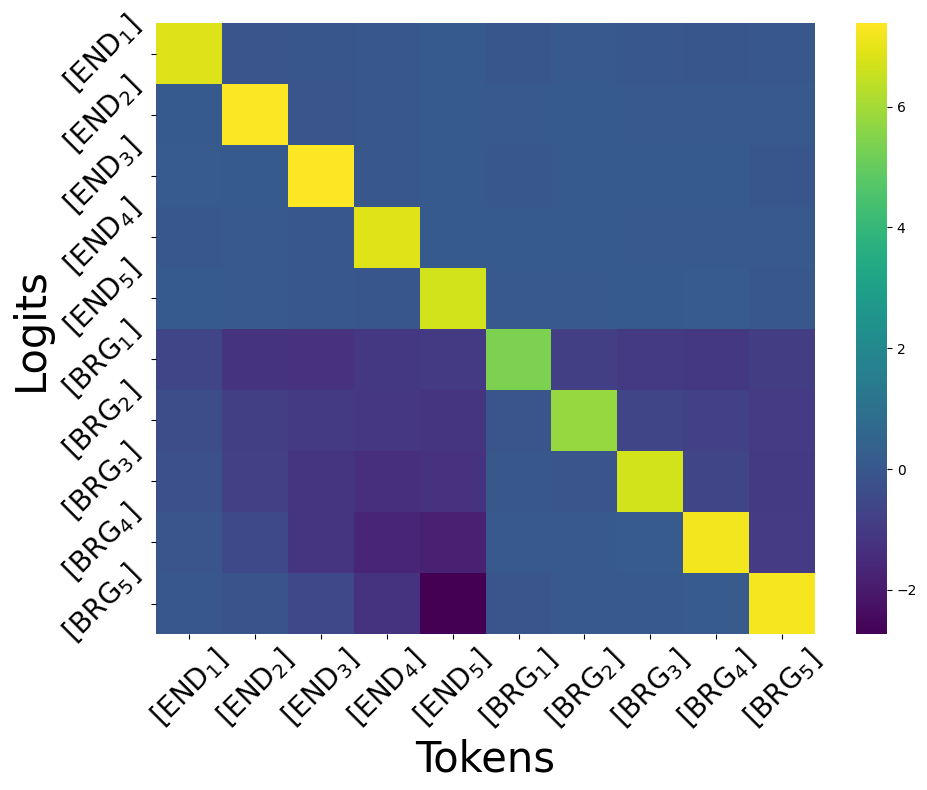

In [40]:
fontsize = 30
# Create row labels (already arranged with end indices first, then mid indices)
end_labels = [rf'[END$_{i+1}$]' for i in range(len(end_indices))]
mid_labels = [rf'[BRG$_{i+1}$]' for i in range(len(mid_indices))]
labels = end_labels + mid_labels

# Visualize filtered output_values in a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(logit_lens.detach().cpu().numpy(), cmap="viridis", annot=False, fmt=".2f")
# plt.title(f"Attention logits on the value states of the second layer")
plt.xlabel("Tokens", fontsize=fontsize)
plt.ylabel("Logits", fontsize=fontsize)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=45, fontsize=fontsize-10)
plt.xticks(np.arange(len(labels)) + 0.5, labels, rotation=45, fontsize=fontsize-10)
plt.tight_layout()
plt.savefig(f"neurips_figures/logit_lens_2_layer.pdf", dpi=300)
plt.show()

In [17]:
subidx = [tok in end_indices or tok in mid_indices for tok in seq]
subidx = subidx[:-1]
[seq[i] for i in relevant_x_indices]

[30, 5, 18, 25, 12, 26, 19, 28, 11, 8]

In [18]:
[output_values[20][idx].item() for idx in relevant_x_indices]

[-0.7070451974868774,
 -0.12633344531059265,
 -0.37990137934684753,
 -0.13851767778396606,
 -0.8825490474700928,
 0.9397100210189819,
 -0.13119810819625854,
 -0.2431822121143341,
 -0.011537894606590271,
 -0.6880559921264648]

In [10]:
logit_lens.mean(dim=0).softmax(dim=0)

tensor([0.1025, 0.1011, 0.1015, 0.1015, 0.1003, 0.0992, 0.0983, 0.0984, 0.0983,
        0.0988], device='cuda:3', grad_fn=<SoftmaxBackward0>)

In [11]:
pred[:, 21, :][0, :].softmax(dim=0)[row_indices]

tensor([0.0019, 0.0038, 0.2342, 0.0332, 0.0004, 0.0050, 0.0013, 0.0076, 0.0046,
        0.0007], device='cuda:3', grad_fn=<IndexBackward0>)

In [12]:
row_indices, twoSum[0]

([5, 18, 12, 30, 25, 11, 8, 19, 28, 26],
 {'target': {'start': [25], 'mid': [24], 'end': [12]},
  'noise': {'start': [5, 26, 22, 17],
   'mid': [6, 8, 23, 20],
   'end': [15, 33, 29, 30]}})

In [13]:
output_values[:, ]

torch.Size([34, 24])